In [1]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import calinski_harabasz_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import os

from models.CAE import CAE
from train import Trainer

from dataloader import ElectricDevices, normalize
from utils import get_shapley_values, baseline

from scipy.ndimage import gaussian_filter1d

import dcor # Székely and Rizzo
from statsmodels.tsa.stattools import acf

import hydra
from hydra.experimental import initialize, initialize_config_dir, compose

torch.manual_seed(4444)
np.random.seed(4444)

Text(0.5, 0, 'alpha')

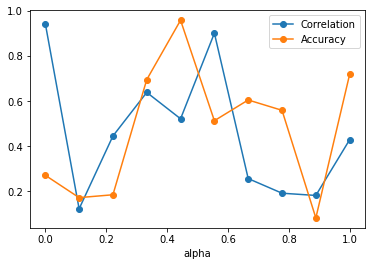

In [2]:
alphas = np.linspace(0, 1, 10)
plt.plot(alphas, np.random.rand(10), "o-", label="Correlation")
plt.plot(alphas, np.random.rand(10), "o-", label="Accuracy")
plt.legend()
plt.xlabel("alpha")

# Create Dataset

In [15]:
abs_config_dir = os.path.abspath("configs")
with initialize_config_dir(config_dir=abs_config_dir):
    cfg = compose(config_name="config")

cfg_dataset, cfg_model, cfg_train = cfg.dataset, cfg.model, cfg.train

n_train, n_valid, n_test = cfg_dataset.n_train, cfg_dataset.n_valid, cfg_dataset.n_test
n = n_train+n_valid+n_test

cfg

{'dataset': {'n_train': 1000, 'n_valid': 100, 'n_test': 100}, 'model': {'M': 4, 'Lf': 3, 'length': 96, 'bottleneck_nn': 24, 'lmd': 1e-05, 'alpha': 0.1}, 'train': {'verbose': True, 'batch_size': 128, 'shuffle': True, 'iters': 3000, 'early_stopping_rounds': 30, 'lr': 0.001}}

## Load observations

In [4]:
data_train_ori, data_valid_ori, data_test_ori = ElectricDevices()
data_train, data_valid, data_test = normalize(data_train_ori), normalize(data_valid_ori), normalize(data_test_ori)
X_train, y_train = data_train[:,:,:-1], data_train[:,:,-1]
X_valid, y_valid = data_valid[:,:,:-1], data_valid[:,:,-1]
X_test, y_test = data_test[:,:,:-1], data_test[:,:,-1]

# Data Exploration

# Compare to baseline

In [5]:
%%script false

baseline(data_train, data_valid, data_test)

Couldn't find program: 'false'


# Model

In [6]:
model = CAE(cfg_model, num_classes=7)

In [16]:
%%script false

trainer = Trainer(cfg_train)
train_losses, valid_losses = trainer.fit(model, data_train, data_valid)

EPOCH 1 train loss: 0.26174156584085956, valid loss: 0.30186913907527924
epochs without improvement: 0

EPOCH 2 train loss: 0.25990621817688786, valid loss: 0.3051026165485382
epochs without improvement: 1

EPOCH 3 train loss: 0.2583390556035503, valid loss: 0.3048756457865238
epochs without improvement: 2

EPOCH 4 train loss: 0.2582546806623859, valid loss: 0.3009476661682129
epochs without improvement: 0

EPOCH 5 train loss: 0.25795540526028604, valid loss: 0.3012266531586647
epochs without improvement: 1

EPOCH 6 train loss: 0.2576688578532588, valid loss: 0.3013942018151283
epochs without improvement: 2

EPOCH 7 train loss: 0.2566008596651016, valid loss: 0.30204301327466965
epochs without improvement: 3

EPOCH 8 train loss: 0.25837422258430914, valid loss: 0.3032314404845238
epochs without improvement: 4

EPOCH 9 train loss: 0.25782419909392634, valid loss: 0.3030540384352207
epochs without improvement: 5

EPOCH 10 train loss: 0.2604036891172009, valid loss: 0.3070666529238224
epo

KeyboardInterrupt: 

In [8]:
%%script false

plt.title("Cost")
plt.plot(train_losses, label="train")
plt.plot(valid_losses, label="validation")
plt.legend()

Couldn't find program: 'false'


## Load/Save model

In [9]:
#%%script false

#torch.save(model.state_dict(), "../saved_models/mod1")
model.load_state_dict(torch.load("../saved_models/mod1"))

<All keys matched successfully>

# Shapley Values

## Shapley value of input with respect to output

In [10]:
%%script false

for focus in [1,3]:
    inp = X_test[focus].reshape((-1,1,96))
    for j in [1,2,3,4]:
        if j == 1:
            result = torch.tensor(gaussian_filter1d(X_test[focus,0], sigma=2)).reshape((1,1,96))
        elif j == 2:
            result = 1-X_test[focus].reshape((-1,1,96))
        elif j == 3:
            result = torch.ones((1,1,96))
        else:
            result = torch.zeros((1,1,96))

        sv_vec = []
        for i in range(96):
            print(i, end=" ")
            sv = get_shapley_values(model, inp, target=i, baselines=result)[0,0]
            sv_vec.append(sv)

        plt.close()
        sns.heatmap(sv_vec, cmap="coolwarm").get_figure().savefig(f"../plots/hm_{focus}-{j}.png")

        ylim = (np.min(sv_vec),1)
        for i in range(96):
            plt.plot(sv_vec[i].flatten())
            plt.plot(inp.detach().numpy().flatten())
            plt.title(f"Position {i}")
            plt.ylim(ylim)
            plt.axvline(x=i, c="red")
            plt.savefig(f"../plots/{focus}-{j}.{i}.png")
            plt.close()
        print()
        print()

Couldn't find program: 'false'


## Layer conductance of bottleneck with respect to output

<AxesSubplot:>

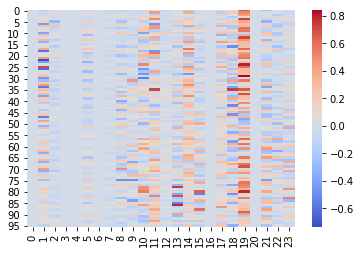

In [11]:
from captum.attr import LayerFeatureAblation
focus = 3
inp = X_test[focus].reshape((-1,1,96))

def model_wrapper(x):
    return model(x)[0]

inp.requires_grad_()

#baselines = tuple(torch.rand((1,1,96)) for _ in range(1000))

cond = LayerFeatureAblation(model_wrapper, model.full_conv_bn)

conds = []
for i in range(96):
    cond_vals = cond.attribute(inp, target=(0,i))
    cond_vals = cond_vals.detach().numpy().flatten()
    conds.append(cond_vals)

sns.heatmap(conds, cmap="coolwarm")

## Input with respect to bottleneck

<AxesSubplot:>

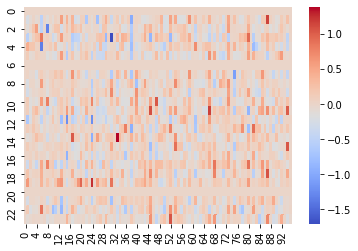

In [12]:
from captum.attr import NeuronFeatureAblation
focus = 3
inp = X_test[focus].reshape((-1,1,96))

def model_wrapper(x):
    return model(x)[0]

inp.requires_grad_()

#baselines = tuple(torch.rand((1,1,96)) for _ in range(1000))

cond = NeuronFeatureAblation(model_wrapper, model.full_conv_bn)

conds = []
for i in range(model.bottleneck_nn):
    cond_vals = cond.attribute(inp, neuron_selector=i)
    cond_vals = cond_vals.detach().numpy().flatten()
    conds.append(cond_vals)
    
sns.heatmap(conds, cmap="coolwarm")

## Average and std correlation

In [13]:
start = 1
n_plots = 5

X_test, y_test = data_test[:,:,:-1], data_test[:,:,-1].numpy()
X_testp, outclass_testp, bn = model(X_test)
X_testp = X_testp.detach().numpy()
probs_testp = torch.nn.functional.softmax(outclass_testp, dim=1)
y_testp = torch.argmax(probs_testp, dim=1).detach().numpy()

# avg and std of cors
cors = dcor.rowwise(dcor.distance_correlation, X_testp[:,0], X_test[:,0])
print("Distance Correlation avg and std:", np.mean(cors), np.std(cors))
print("NRMSE:", (torch.sqrt(torch.mean(torch.square(X_test-X_testp)))/(torch.max(X_test)-torch.min(X_test))).item())
print()

fig, axs = plt.subplots(nrows=2, ncols=n_plots, figsize=(25,5))
for i in range(n_plots):
    vals = data_test_ori[i,0,:-1]
    min_v, max_v = torch.min(vals), torch.max(vals)
    axs[0,i].set_title(f"Original (class {int(y_test[n_plots*start+i][0])}) (min={min_v:.2f}, max={max_v:.2f})")
    axs[0,i].plot(X_test[n_plots*start+i,0])
    axs[0,i].axis("off")
    axs[0,i].set_ylim((0,1))

    axs[1,i].set_title(f"Recon (with ylim) (pred class {int(y_testp[n_plots*start+i])})")
    axs[1,i].plot(X_testp[n_plots*start+i,0])
    axs[1,i].axis("off")
    axs[1,i].set_ylim((0,1))

    print("cor:", distance_correlation(X_testp[start+i,0], X_test[start+i,0]))

Distance Correlation avg and std: 0.7381518 0.23248081
NRMSE: 0.19210076332092285



NameError: name 'distance_correlation' is not defined

Accuracy: 0.606795486966671


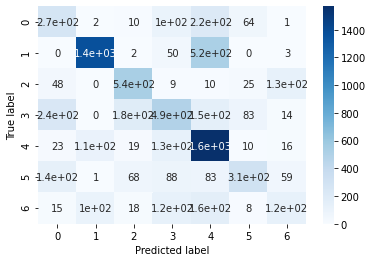

In [14]:
cm = confusion_matrix(y_test, y_testp)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")

print("Accuracy:", np.sum(np.diag(cm))/np.sum(cm))

# Checking important filters

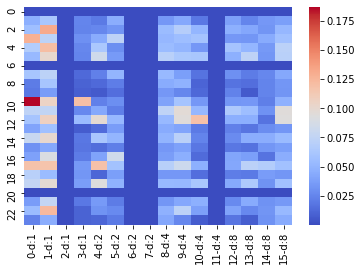

In [15]:
num_filter = model.k*model.M
w_per_filter = model.length
num_neurons = model.bottleneck_nn
M = model.M

w = np.array([[torch.mean(torch.abs(model.full_conv_bn.weight[j,i*w_per_filter:(i+1)*w_per_filter])).item() for i in range(num_filter)] for j in range(num_neurons)])

x_axis_labels = [f"{i}-d:{model.dilation[i//M]}" for i in range(w.shape[1])]
_ = sns.heatmap(w, cmap="coolwarm", xticklabels=x_axis_labels)

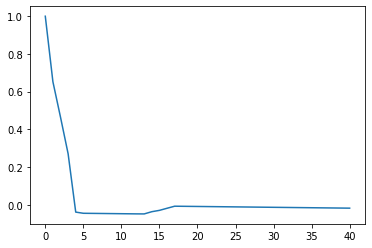

In [16]:
plt.plot(acf(X_test[4,0]))